In [9]:
#LIB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
import pandas as pd
import seaborn as sns
import cv2

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add, Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import accuracy_score





tf.config.threading.set_intra_op_parallelism_threads(5)  # Adjust number of threads
tf.config.threading.set_inter_op_parallelism_threads(5)


In [2]:
import tensorflow as tf
 
print(tf.__version__)
@tf.function
def test_device():
    a = tf.constant([[1.0]])
    b = tf.constant([[2.0]])
    c = tf.matmul(a, b)
    return c

result = test_device()
print("Tensor placed on:", result.device)
from tensorflow.python.client import device_lib
for device in device_lib.list_local_devices():
    if device.device_type == 'GPU':
        print(f"Name: {device.name}, Description: {device.physical_device_desc}")
from tensorflow.python.framework import test_util
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("Built with ROCm:", tf.test.is_built_with_rocm())
print("Built with DML:", hasattr(tf.raw_ops, 'DmlReduce'))


2.10.0
Tensor placed on: /job:localhost/replica:0/task:0/device:CPU:0
Built with CUDA: False
Built with ROCm: False
Built with DML: False


In [2]:
#IMG PLOT

['Blazer', 'Celana_Panjang', 'Celana_Pendek', 'Gaun', 'Hoodie', 'Jaket', 'Jaket_Denim', 'Jaket_Olahraga', 'Jeans', 'Kaos', 'Kemeja', 'Mantel', 'Polo', 'Rok', 'Sweter']


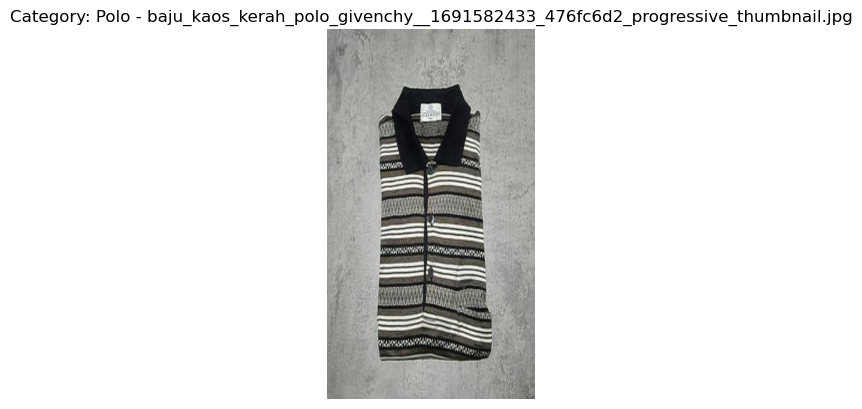

In [5]:
base_dir = "Img_70"
categories = os.listdir(base_dir)
print(categories)

category = random.choice(categories) 
category_path = os.path.join(base_dir, category)
images = os.listdir(category_path)
img_name = random.choice(images)
img_path = os.path.join(category_path, img_name)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Category: {category} - {img_name}")
plt.axis("off")
plt.show()

In [7]:


# Parametri
img_size = (128, 128)  # Dimensione a cui ridimensionare le immagini
batch_size = 32

# Creazione del data generator per train e validation set
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255,horizontal_flip=True, rotation_range=20,zoom_range=0.2)

datagen2 = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = datagen2.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=99
)

val_generator = datagen2.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Stampa le classi trovate
print(train_generator.class_indices)


Found 4801 images belonging to 15 classes.
Found 1192 images belonging to 15 classes.
{'Blazer': 0, 'Celana_Panjang': 1, 'Celana_Pendek': 2, 'Gaun': 3, 'Hoodie': 4, 'Jaket': 5, 'Jaket_Denim': 6, 'Jaket_Olahraga': 7, 'Jeans': 8, 'Kaos': 9, 'Kemeja': 10, 'Mantel': 11, 'Polo': 12, 'Rok': 13, 'Sweter': 14}


In [9]:
### ALEX NET
def alex_net():
    model = Sequential([
    # Primo blocco convoluzionale
    Conv2D(96, (11, 11), strides=2, activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    BatchNormalization(),

    # Secondo blocco convoluzionale
    Conv2D(256, (5, 5), padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2),
    BatchNormalization(),

    # Terzo blocco convoluzionale
    Conv2D(384, (3, 3), padding="same", activation='relu'),

    # Quarto blocco convoluzionale
    Conv2D(384, (3, 3), padding="same", activation='relu'),

    # Quinto blocco convoluzionale
    Conv2D(256, (3, 3), padding="same", activation='relu'),
    MaxPooling2D(pool_size=(3, 3), strides=2),

    # Flatten per passare ai livelli densi
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    
    # Output layer - cambia NUM_CLASSI con il numero delle tue classi
    Dense(15, activation='softmax') ])
    # Compilazione del modello
    model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
    return model
    

In [11]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

model = alex_net()

history = model.fit(train_generator, validation_data=val_generator, epochs=40, callbacks=callbacks2)

Epoch 1/40
151/151 [==============================] - 90s 590ms/step - loss: 2.7890 - accuracy: 0.0556 - val_loss: 2.7082 - val_accuracy: 0.0671 - lr: 0.0010
Epoch 2/40
151/151 [==============================] - 69s 454ms/step - loss: 2.7092 - accuracy: 0.0617 - val_loss: 2.7081 - val_accuracy: 0.0654 - lr: 0.0010
Epoch 3/40
151/151 [==============================] - 68s 450ms/step - loss: 2.7092 - accuracy: 0.0602 - val_loss: 2.7081 - val_accuracy: 0.0671 - lr: 0.0010
Epoch 4/40
151/151 [==============================] - 69s 457ms/step - loss: 2.7088 - accuracy: 0.0598 - val_loss: 2.7081 - val_accuracy: 0.0671 - lr: 0.0010
Epoch 5/40
151/151 [==============================] - 68s 452ms/step - loss: 2.7087 - accuracy: 0.0606 - val_loss: 2.7081 - val_accuracy: 0.0663 - lr: 3.0000e-04
Epoch 6/40
151/151 [==============================] - 68s 453ms/step - loss: 2.7085 - accuracy: 0.0642 - val_loss: 2.7081 - val_accuracy: 0.0671 - lr: 3.0000e-04
Epoch 7/40
151/151 [========================

In [31]:
model.save('my_model_alex_net')

INFO:tensorflow:Assets written to: my_model_alex_net\assets


INFO:tensorflow:Assets written to: my_model_alex_net\assets


In [41]:
def sequential_model():
    model = Sequential([
    Conv2D(32, (5,5), activation='relu', input_shape=(128, 128,3), padding="same"),
    MaxPooling2D(2,2, padding="same"),
    BatchNormalization(),

    Conv2D(64, (5,5), activation='relu', padding="same"),
    Conv2D(64, (5,5), activation='relu', padding="same"),
    Conv2D(64, (5,5), activation='relu', padding="same"),
    
    MaxPooling2D(2,2, padding="same"),
    BatchNormalization(),

    Conv2D(128, (5,5), activation='relu', padding="same"),
    Conv2D(128, (5,5), activation='relu', padding="same"),
    Conv2D(128, (5,5), activation='relu', padding="same"),
    
    MaxPooling2D(2,2, padding="same"),
    BatchNormalization(),

    Conv2D(256, (5,5), activation='relu', padding="same"),
    Conv2D(256, (5,5), activation='relu', padding="same"),
    Conv2D(256, (5,5), activation='relu', padding="same"),
    
    MaxPooling2D(2,2, padding="same"),
    BatchNormalization(),

    #Conv2D(512, (5,5), activation='relu', padding="same"),
    #MaxPooling2D(2,2, padding="same"),
    #BatchNormalization(),

    #Conv2D(1024, (5,5), activation='relu', padding="same"),
    Conv2D(512, (5,5), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(1,1)), 
    BatchNormalization(),

    GlobalAveragePooling2D(), 

    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),

    Dense(len(train_generator.class_indices), activation='softmax') ])
    
    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
    return model

In [43]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

model = sequential_model()

history = model.fit(train_generator, validation_data=val_generator, epochs=40, callbacks=callbacks2)

Epoch 1/40
151/151 [==============================] - 82s 542ms/step - loss: 2.8319 - accuracy: 0.0914 - val_loss: 2.7324 - val_accuracy: 0.0956 - lr: 0.0010
Epoch 2/40
151/151 [==============================] - 78s 516ms/step - loss: 2.5717 - accuracy: 0.1414 - val_loss: 2.6807 - val_accuracy: 0.0847 - lr: 0.0010
Epoch 3/40
151/151 [==============================] - 82s 540ms/step - loss: 2.4970 - accuracy: 0.1762 - val_loss: 2.8606 - val_accuracy: 0.1418 - lr: 0.0010
Epoch 4/40
151/151 [==============================] - 81s 535ms/step - loss: 2.4132 - accuracy: 0.2037 - val_loss: 2.5015 - val_accuracy: 0.1502 - lr: 0.0010
Epoch 5/40
151/151 [==============================] - 80s 526ms/step - loss: 2.3262 - accuracy: 0.2322 - val_loss: 2.4996 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 6/40
151/151 [==============================] - 78s 516ms/step - loss: 2.2389 - accuracy: 0.2679 - val_loss: 2.4423 - val_accuracy: 0.2122 - lr: 0.0010
Epoch 7/40
151/151 [==============================] 

In [45]:
model.save('my_model_sequential_model')

INFO:tensorflow:Assets written to: my_model_sequential_model\assets


INFO:tensorflow:Assets written to: my_model_sequential_model\assets


In [47]:
def sequential_model2():
    model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),  

   
    Dense(len(train_generator.class_indices), activation='softmax') ])
    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
    return model

In [49]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

model = sequential_model2()

history = model.fit(train_generator, validation_data=val_generator, epochs=40, callbacks=callbacks2)

Epoch 1/40
151/151 [==============================] - 76s 497ms/step - loss: 2.9352 - accuracy: 0.1410 - val_loss: 2.7992 - val_accuracy: 0.0696 - lr: 0.0010
Epoch 2/40
151/151 [==============================] - 73s 482ms/step - loss: 2.4943 - accuracy: 0.1948 - val_loss: 2.6087 - val_accuracy: 0.1384 - lr: 0.0010
Epoch 3/40
151/151 [==============================] - 74s 489ms/step - loss: 2.3587 - accuracy: 0.2414 - val_loss: 2.3845 - val_accuracy: 0.2139 - lr: 0.0010
Epoch 4/40
151/151 [==============================] - 79s 519ms/step - loss: 2.1422 - accuracy: 0.2997 - val_loss: 2.2507 - val_accuracy: 0.2601 - lr: 0.0010
Epoch 5/40
151/151 [==============================] - 74s 489ms/step - loss: 2.0352 - accuracy: 0.3395 - val_loss: 2.1283 - val_accuracy: 0.2995 - lr: 0.0010
Epoch 6/40
151/151 [==============================] - 73s 480ms/step - loss: 1.9495 - accuracy: 0.3674 - val_loss: 2.1204 - val_accuracy: 0.3096 - lr: 0.0010
Epoch 7/40
151/151 [==============================] 

In [51]:
model.save('my_model_sequential_model2')

INFO:tensorflow:Assets written to: my_model_sequential_model2\assets


INFO:tensorflow:Assets written to: my_model_sequential_model2\assets


In [65]:
def sequential_model3():
    model = Sequential([
    Conv2D(32, (5,5), activation='relu', input_shape=(128, 128,3), padding="same"),
    MaxPooling2D(2,2, padding="same"),
    BatchNormalization(),

    Conv2D(64, (5,5), activation='relu', padding="same"),
    MaxPooling2D(2,2, padding="same"),
    BatchNormalization(),

    Conv2D(128, (5,5), activation='relu', padding="same"),
    MaxPooling2D(2,2, padding="same"),
    BatchNormalization(),

    Conv2D(256, (5,5), activation='relu', padding="same"),
    MaxPooling2D(2,2, padding="same"),
    BatchNormalization(),

    Conv2D(512, (5,5), activation='relu', padding="same"),
     MaxPooling2D(2,2, padding="same"),
    BatchNormalization(),

    Conv2D(1024, (5,5), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(1,1)),  
    BatchNormalization(),

    GlobalAveragePooling2D(),  

    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),

    Dense(len(train_generator.class_indices), activation='softmax')])
    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
    return model


In [67]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

model = sequential_model3()

history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=callbacks2)

Epoch 1/50
151/151 [==============================] - 98s 646ms/step - loss: 3.0028 - accuracy: 0.1000 - val_loss: 2.7176 - val_accuracy: 0.0822 - lr: 0.0010
Epoch 2/50
151/151 [==============================] - 96s 633ms/step - loss: 2.5543 - accuracy: 0.1606 - val_loss: 2.8739 - val_accuracy: 0.0956 - lr: 0.0010
Epoch 3/50
151/151 [==============================] - 96s 632ms/step - loss: 2.4401 - accuracy: 0.1939 - val_loss: 2.6554 - val_accuracy: 0.1552 - lr: 0.0010
Epoch 4/50
151/151 [==============================] - 96s 636ms/step - loss: 2.3613 - accuracy: 0.2368 - val_loss: 2.8020 - val_accuracy: 0.1619 - lr: 0.0010
Epoch 5/50
151/151 [==============================] - 96s 635ms/step - loss: 2.2721 - accuracy: 0.2516 - val_loss: 2.4555 - val_accuracy: 0.1921 - lr: 0.0010
Epoch 6/50
151/151 [==============================] - 96s 633ms/step - loss: 2.1850 - accuracy: 0.2766 - val_loss: 2.7151 - val_accuracy: 0.1795 - lr: 0.0010
Epoch 7/50
151/151 [==============================] 

In [69]:
model.save('my_model_sequential_model3')

INFO:tensorflow:Assets written to: my_model_sequential_model3\assets


INFO:tensorflow:Assets written to: my_model_sequential_model3\assets


In [71]:

def sequential_model4():
    model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu', padding='same', strides=2),  # strides=2 downsamples here
    BatchNormalization(),

    Conv2D(256, (3,3), activation='relu', padding='same', strides=2),
    BatchNormalization(),

    Conv2D(512, (3,3), activation='relu', padding='same', strides=2),
    BatchNormalization(),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),

    Dense(len(train_generator.class_indices), activation='softmax')])
    model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
    return model

In [73]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)
]

model = sequential_model4()

history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=callbacks2)

Epoch 1/50
151/151 [==============================] - 69s 454ms/step - loss: 3.2239 - accuracy: 0.1173 - val_loss: 2.7081 - val_accuracy: 0.0872 - lr: 0.0010
Epoch 2/50
151/151 [==============================] - 68s 448ms/step - loss: 2.6467 - accuracy: 0.1552 - val_loss: 2.6797 - val_accuracy: 0.1208 - lr: 0.0010
Epoch 3/50
151/151 [==============================] - 69s 456ms/step - loss: 2.5230 - accuracy: 0.1752 - val_loss: 2.6238 - val_accuracy: 0.1477 - lr: 0.0010
Epoch 4/50
151/151 [==============================] - 69s 455ms/step - loss: 2.5042 - accuracy: 0.1864 - val_loss: 2.8274 - val_accuracy: 0.1057 - lr: 0.0010
Epoch 5/50
151/151 [==============================] - 68s 448ms/step - loss: 2.4629 - accuracy: 0.1945 - val_loss: 2.6192 - val_accuracy: 0.1200 - lr: 0.0010
Epoch 6/50
151/151 [==============================] - 68s 448ms/step - loss: 2.4198 - accuracy: 0.2031 - val_loss: 2.8207 - val_accuracy: 0.1208 - lr: 0.0010
Epoch 7/50
151/151 [==============================] 

In [75]:
model.save('my_model_sequential_model4')

INFO:tensorflow:Assets written to: my_model_sequential_model4\assets


INFO:tensorflow:Assets written to: my_model_sequential_model4\assets


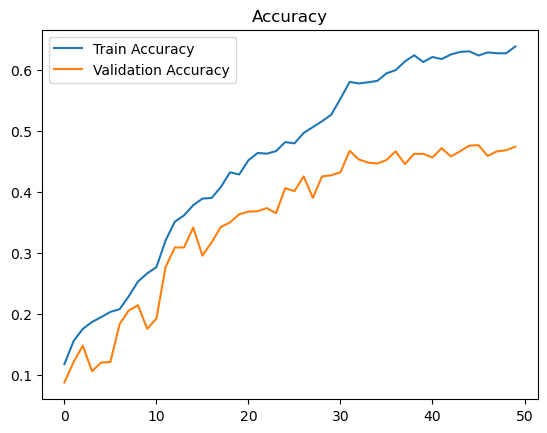

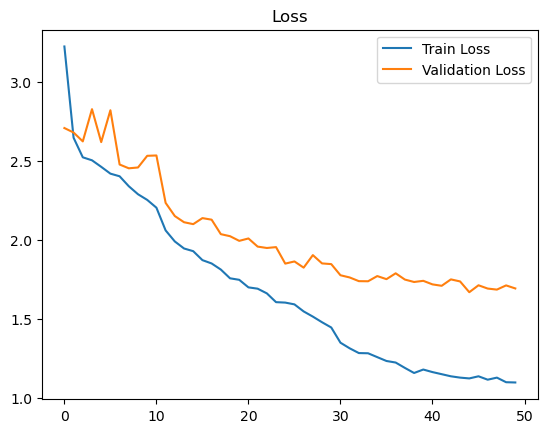

In [77]:
# Grafico di accuratezza
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Grafico di perdita
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [85]:
from tensorflow.keras.models import load_model

def evaluate_model_on_directory(model, base_dir="Img_pred", img_size=(128, 128), batch_size=32):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(
        base_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    predictions = model.predict(generator, verbose=0)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes

    acc = accuracy_score(true_classes, predicted_classes)
    return acc

models = {
    "alex_net": load_model('my_model_alex_net'),
    "sequential_model": load_model('my_model_sequential_model'),
    "sequential_model2": load_model('my_model_sequential_model2'),
    "sequential_model3": load_model('my_model_sequential_model3'),
    "sequential_model4": load_model('my_model_sequential_model4')
}

for model_name, model in models.items():
    acc = evaluate_model_on_directory(model)
    print(f"{model_name} accuracy: {acc:.4f}")

Found 216 images belonging to 15 classes.
alex_net accuracy: 0.0648
Found 216 images belonging to 15 classes.
sequential_model accuracy: 0.5833
Found 216 images belonging to 15 classes.
sequential_model2 accuracy: 0.5787
Found 216 images belonging to 15 classes.
sequential_model3 accuracy: 0.5509
Found 216 images belonging to 15 classes.
sequential_model4 accuracy: 0.4861


In [ ]:
#ESEMPIO CODICE PER UTILIZZO RESNET

from tensorflow.keras.applications import ResNet50

# Carica il modello ResNet
base_model = ResNet50(weights=None, include_top=False, input_shape=(*img_size, 3))
base_model.load_weights('./Modelli/resnet50_weights.h5')
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  
x = Dense(256, activation='relu')(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)
model.save('ResNet')

models = {
    "ResNet": load_model('ResNet')
}

for model_name, model in models.items():
    acc = evaluate_model_on_directory(model)
    print(f"{model_name} accuracy: {acc:.4f}")